Alinging images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 1
Finished aligning band 3
Finished aligning band 4
Finished aligning band 2
Finished aligning band 0
Aligining complete


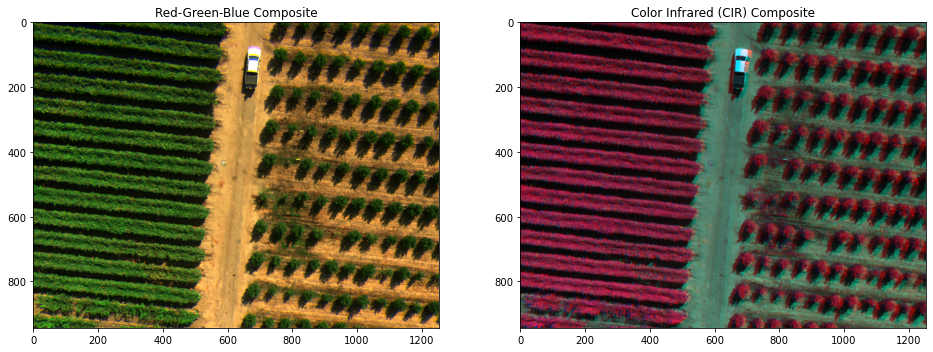

Panel Calculation Executed


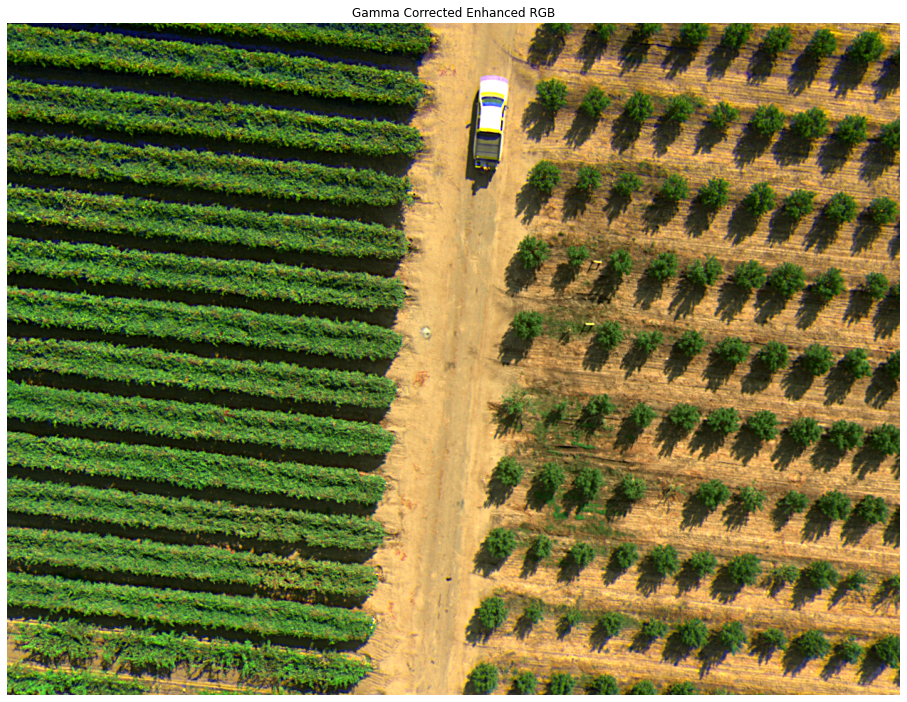

Image write done


In [2]:
def img_enhance():
    %reload_ext autoreload
    %autoreload 2
    import os, glob
    import micasense.capture as capture
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    import micasense.imageutils as imageutils
    import micasense.plotutils as plotutils
    from osgeo import gdal, gdal_array
    from micasense import plotutils
    %matplotlib inline
    import pandas as pd
    panelNames = None 
    
    imageprefix='IMG_0001'
    final_image_prefix=imageprefix+'_*.tif';

    panelprefix='IMG_0000'
    final_panel_prefix=panelprefix+'_*.tif';
    imagePath = os.path.join('.','Dataset','Dataset_1')
    imageNames = glob.glob(os.path.join(imagePath,final_image_prefix)) #includes all images with prefix IMG_0001_ALL.TIF
    panelNames = glob.glob(os.path.join(imagePath,final_panel_prefix)) #includes all images with prefix IMG_0000_ALL.TIF

    if panelNames is not None:
        panelCap = capture.Capture.from_filelist(panelNames)
    else:
        panelCap = None

    capture = capture.Capture.from_filelist(imageNames)
    
    if panelCap is not None:
        if panelCap.panel_albedo() is not None:
            panel_reflectance_by_band = panelCap.panel_albedo() # Auto detect the panel and if not proceed to else with manual declaration
        else:
            panel_reflectance_by_band = [0.67, 0.69, 0.68, 0.61, 0.67] #RedEdge band_index order
        panel_irradiance = panelCap.panel_irradiance(panel_reflectance_by_band)    
        img_type = "reflectance"
        #capture.plot_undistorted_reflectance(panel_irradiance)
    else:
        if capture.dls_present():
            img_type='reflectance'
            #capture.plot_undistorted_reflectance(capture.dls_irradiance())
        else:
            img_type = "radiance"
            #capture.plot_undistorted_radiance()
            
    

    ## Alignment settings
    match_index = 1 # Index of the band 
    max_alignment_iterations = 10
    warp_mode = cv2.MOTION_HOMOGRAPHY # MOTION_HOMOGRAPHY or MOTION_AFFINE. For Altum images only use HOMOGRAPHY
    pyramid_levels = 0 # for images with RigRelatives, setting this to 0 or 1 may improve alignment

    print("Alinging images. Depending on settings this can take from a few seconds to many minutes")
    # Can potentially increase max_iterations for better results, but longer runtimes
    warp_matrices, alignment_pairs = imageutils.align_capture(capture,
                                                              ref_index = match_index,
                                                              max_iterations = max_alignment_iterations,
                                                              warp_mode = warp_mode,
                                                              pyramid_levels = pyramid_levels)

    #print("Finished Aligning, warp matrices={}".format(warp_matrices))
    print("Aligining complete")
    
    cropped_dimensions, edges = imageutils.find_crop_bounds(capture, warp_matrices, warp_mode=warp_mode)
    im_aligned = imageutils.aligned_capture(capture, warp_matrices, warp_mode, cropped_dimensions, match_index, img_type=img_type)
    
    # figsize=(30,23) # use this size for full-image-resolution display
    figsize=(16,13)   # use this size for export-sized display

    rgb_band_indices = [capture.band_names_lower().index('red'),
                        capture.band_names_lower().index('green'),
                        capture.band_names_lower().index('blue')]
    cir_band_indices = [capture.band_names_lower().index('nir'),
                        capture.band_names_lower().index('red'),
                        capture.band_names_lower().index('green')]

    # Create a normalized stack for viewing
    im_display = np.zeros((im_aligned.shape[0],im_aligned.shape[1],im_aligned.shape[2]), dtype=np.float32 )

    im_min = np.percentile(im_aligned[:,:,rgb_band_indices].flatten(), 0.5)  # modify these percentiles to adjust contrast
    im_max = np.percentile(im_aligned[:,:,rgb_band_indices].flatten(), 99.5)  # for many images, 0.5 and 99.5 are good values

    # for rgb true color, we use the same min and max scaling across the 3 bands to 
    # maintain the "white balance" of the calibrated image
    for i in rgb_band_indices:
        im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i], im_min, im_max)

    rgb = im_display[:,:,rgb_band_indices]

    # for cir false color imagery, we normalize the NIR,R,G bands within themselves, which provides
    # the classical CIR rendering where plants are red and soil takes on a blue tint
    for i in cir_band_indices:
        im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i])

    cir = im_display[:,:,cir_band_indices]
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes[0].set_title("Red-Green-Blue Composite")
    axes[0].imshow(rgb)
    axes[1].set_title("Color Infrared (CIR) Composite")
    axes[1].imshow(cir)
    plt.show()
    print("Panel Calculation Executed")
    
    
    # Create an enhanced version of the RGB render using an unsharp mask
    gaussian_rgb = cv2.GaussianBlur(rgb, (9,9), 10.0)
    gaussian_rgb[gaussian_rgb<0] = 0
    gaussian_rgb[gaussian_rgb>1] = 1
    unsharp_rgb = cv2.addWeighted(rgb, 1.5, gaussian_rgb, -0.5, 0)
    unsharp_rgb[unsharp_rgb<0] = 0
    unsharp_rgb[unsharp_rgb>1] = 1

    # Apply a gamma correction to make the render appear closer to what our eyes would see
    gamma = 1.4
    gamma_corr_rgb = unsharp_rgb**(1.0/gamma)
    fig = plt.figure(figsize=figsize)
    plt.imshow(gamma_corr_rgb, aspect='equal')
    plt.title(label = 'Gamma Corrected Enhanced RGB')
    plt.axis('off')
    plt.show()
    
    
    #save the image
    import imageio
    imtype = 'png' # or 'jpg'
    imageio.imwrite('static/Output/rgb.'+imtype, (255*gamma_corr_rgb).astype('uint8'))
    imageio.imwrite('static/output/cir.'+imtype, (255*cir).astype('uint8'))
    print("Image write done")

img_enhance()